## Frequency

In [1]:
import epics
import numpy
import pandas
import torch
import nufft

from harmonica.util import LENGTH
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
torch.cuda.is_available()

True

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))


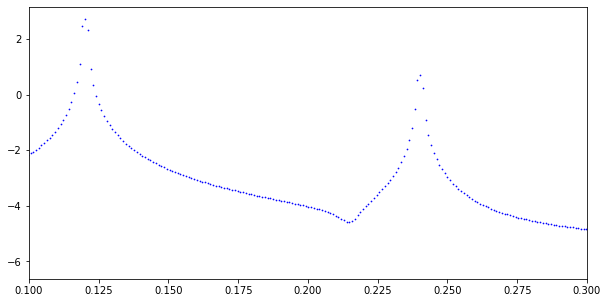

In [2]:
# Example-01: FFT amplitude spectrum

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Apply window
f.data.window_apply()

# FFT grid is stored in fft_grid (computed on initialization)
# FFT spectrum amplitudes are stored in fft_spectrum for each signal

# Compute FFT amplitude spectrum
f.fft_get_spectrum()

# Reset TbT work
f.data.reset()

# Plot FFT spectrum for given signal id
idx = 0
plt.figure(figsize=(10,5))
plt.scatter(f.fft_grid.cpu(), torch.log10(f.fft_spectrum[idx].cpu()), s=0.5, c='b')
plt.xlim(0.1, 0.3)
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))


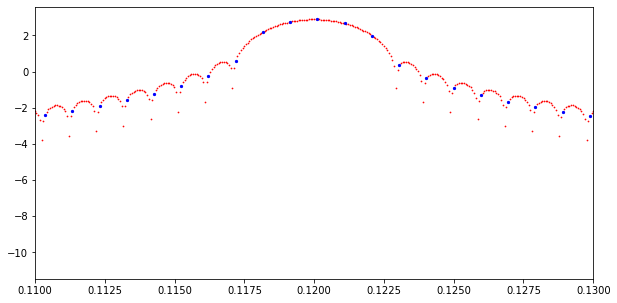

In [3]:
# Example-02: FFT amplitude spectrum & zero padding

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# If pad == 0, it is set to signal length
# Spectrum is computed using torch.fft.rfft(..., n=pad)
# Padding can be used to interpolate DTFT spectrum in all frequency range
# This improves frequency estimation accuracy (assuming frequency corresponds to max of the largest FFT spectrum amplitude peak)
# Can be used to obtain a better initial guess, if signal has several frequencies with close amplitudes

# Initialize Frequency instances with and without padding
f1 = Frequency(tbt, pad=length*2**4)
f2 = Frequency(tbt, pad=length*2**0)
print(f1)
print(f2)

# Apply window to data
f1.data.window_apply()
f2.data.window_apply()

# Compute FFT amplitude spectrum
f1.fft_get_spectrum()
f2.fft_get_spectrum()

# Reset TbT work
f1.data.reset()
f2.data.reset()

# Plot (log10) FFT spectrum for given signal id
idx = 0
plt.figure(figsize=(10,5))
plt.scatter(f1.fft_grid.detach().cpu(), torch.log10(f1.fft_spectrum[idx].detach().cpu()), s=0.5, c='r')
plt.scatter(f2.fft_grid.detach().cpu(), torch.log10(f2.fft_spectrum[idx].detach().cpu()), s=5.0, c='b')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.show()

# Clean
del win
del tbt
del f1, f2
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

In [4]:
# Example-03: FFT frequency estimation & zero padding

# FFT frequency estimation is based on location of max bin in the amplitude spectum

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Initialize Frequency instances with and without padding
f1 = Frequency(tbt, pad=length*2**0)
f2 = Frequency(tbt, pad=length*2**4)
print(f1)
print(f2)

# Estimate frequency
f1('fft')
f2('fft')

# Compare results
print(torch.min(f1.frequency - 0.12))
print(torch.min(f2.frequency - 0.12))

# In this case call invokes task_fft method
f1.task_fft(window=True)
f2.task_fft(window=True)

# Clean
del win
del tbt
del f1, f2
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(-4.882812499996e-06, dtype=torch.float64)


In [5]:
# Example-04: FFT frequency estimation & zero padding for given range

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Initialize Frequency instances with and without padding
f1 = Frequency(tbt, pad=length*2**0)
f2 = Frequency(tbt, pad=length*2**4)
print(f1)
print(f2)

# By default FFT frequency estimation is performed using (0.0, 0.5) frequency range.
# Explicit range can be passed.

# Estimate frequency for explicit frequency range
f1('fft', f_range=(0.2, 0.25))
f2('fft', f_range=(0.2, 0.25))

# Compare results
print(torch.min(f1.frequency - 0.24))
print(torch.min(f2.frequency - 0.24))

# Clean
del win
del tbt
del f1, f2
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
tensor(2.343750000000e-04, dtype=torch.float64)
tensor(-9.765624999991e-06, dtype=torch.float64)


Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
tensor([1.191406250000e-01, 1.210918426514e-01], dtype=torch.float64)
tensor([1.191406250000e-01, 1.210937500000e-01], dtype=torch.float64)
tensor([1.191406250000e-01, 1.210937500000e-01], dtype=torch.float64)


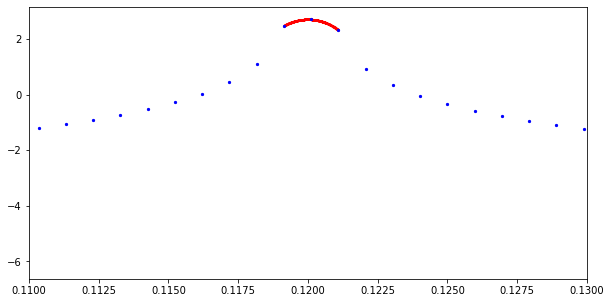

tensor([1.150000000000e-01, 1.249902343750e-01], dtype=torch.float64)
tensor([1.150000000000e-01, 1.250000000000e-01], dtype=torch.float64)


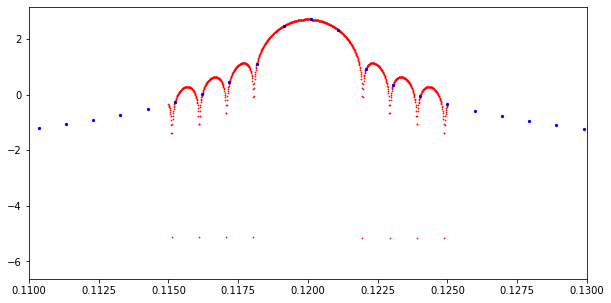

In [6]:
# Example-05: FFRFT amplitude spectrum

# FFRFT can be used for local DTFT spectrum interpolation

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Apply window to data
f.data.window_apply()

# Compute FFT amplitude spectrum
f.fft_get_spectrum()

# By default for FFRFT spectrum, FFT frequency estimation is used
# And frequency range is equal to 2 FFT bins around max FFT bin
# This can be changed by setting fraction parameter on initialization
# Or by setting ffrft_span attibute directry after initialization
# Use default value.
f.ffrft_span = 2.0/f.length

# If ffrft_flag is False, ffrft_initialize_spectrum is invoked
# ffrft_flag is set to True, futher calls do not reinitialize FFRFT
# No need to initialize for fixed signal length

# Compute FFT frequency estimation (used to define FFRFT frequency center)
f.fft_get_frequency()

# Compute FFRFT amplitude spectrum
f.ffrft_get_spectrum()

# Note, last point is not included
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1]]))
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1] + f.ffrft_span*f.fft_step]))
print(torch.stack([f.fft_frequency[0] - f.fft_step, f.fft_frequency[0] + f.fft_step]))

# Plot (log10) FFT spectrum for given signal id
idx = 0
plt.figure(figsize=(10,5))
plt.scatter(f.ffrft_get_grid(idx).cpu(), torch.log10(f.ffrft_spectrum[idx].cpu()), s=0.5, c='r')
plt.scatter(f.fft_grid.cpu(), torch.log10(f.fft_spectrum[idx].cpu()), s=5.0, c='b')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.show()

# FFRFT can be used with custom range
# In this case all signals share this range, while for the default case, each signal range is defined by its FFT frequency
# In all cases range length is the same for all signals

# Compute FFRFT amplitude spectrum with custom range
# Range (f_min, f_max) = (center - 0.5*span, center + 0.5*span - span/length)
f.ffrft_get_spectrum(center=0.12, span=0.01)

# Note, last point is not included
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1]]))
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1] + f.ffrft_span*f.fft_step]))

# Plot (log10) FFT spectrum for given signal id
idx = 0
plt.figure(figsize=(10,5))
plt.scatter(f.ffrft_get_grid(idx).cpu(), torch.log10(f.ffrft_spectrum[idx].cpu()), s=0.5, c='r')
plt.scatter(f.fft_grid.cpu(), torch.log10(f.fft_spectrum[idx].cpu()), s=5.0, c='b')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

In [7]:
# Example-06: FFRFT frequency estimation

# FFRFT frequency estimation is based on local DTFT spectrum interpolation (near expected global maximum)
# By default refined spectum is computed inside two FFT bins around maximum bin
# In this case expected frequency error is proportional to 1/n^2

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Initialize Frequency instance
f1 = Frequency(tbt)
f2 = Frequency(tbt, fraction=1.0)
print(f1)
print(f2)

# Fraction between 1.0-2.0 should be save to use

# Estimate frequency, see also task_ffrft
f1('ffrft')
f2('ffrft')

# Compare results FFT & FFRFT estimations
print(torch.min(f1.fft_frequency - 0.12))
print(torch.min(f2.fft_frequency - 0.12))
print(torch.min(f1.ffrft_frequency - 0.12))
print(torch.min(f2.ffrft_frequency - 0.12))

# Clean
del win
del tbt
del f1, f2
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(8.392333984419e-07, dtype=torch.float64)
tensor(-1.144409179643e-07, dtype=torch.float64)


In [8]:
# Example-07: Parabola frequency estimation

# Parabola frequency estimation is based on parabolic interpolation of FFRFT amplitude spectrum
# Three points are used to locate parabola maximum (FFRFT max bin and two poins around it)
# Higher order polynomial can be used or a gradient free bracketing maximum search
# Instead of interpolation, a polynomial (e.g. a parabola) can be fitted near the peak maximum
# Without noise, parabolic interpolation significantly improves estimation accuracy
# Window order impoves accuracy in this case too (flat top)
# With noise accuracy gain from parabolic interpolation decreases
# Application of window increases noise

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (64 signals with two components and different amplitudes)
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Estimate frequency, see also task_parabola
f('parabola')

# Compare results
print(torch.mean(f.fft_frequency)-0.12)
print(torch.mean(f.ffrft_frequency)-0.12)
print(torch.mean(f.parabola_frequency)-0.12)

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(8.392333984419e-07, dtype=torch.float64)
tensor(3.001190962415e-11, dtype=torch.float64)


Window(2048, 'cosine_window', 1.0)
Data(1, Window(2048, 'cosine_window', 1.0))
Data(1025, Window(1024, 'cosine_window', 1.0))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(8.392333984419e-07, dtype=torch.float64)
tensor(-4.614364446098e-14, dtype=torch.float64)


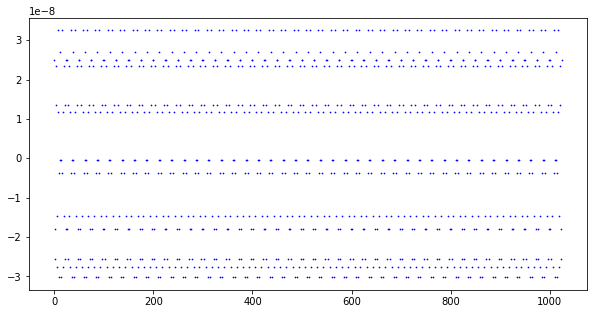

In [9]:
# Example-08: Frequency vs signal start shift

# Set parameters (1 signal with length 2048)
dtype, device = torch.float64, 'cpu'
size, length = 1, 2048

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (1 signals with two components)
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Generate matrix frim signal
tbt = tbt.make_matrix(0, 1024, 1, name='cosine_window', order=1.0)
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)

# Estimate frequency
f('parabola')
print(torch.mean(f.fft_frequency)-0.12)
print(torch.mean(f.ffrft_frequency)-0.12)
print(torch.mean(f.parabola_frequency)-0.12)

# Plot result
shift = torch.linspace(0, len(tbt)-1, len(tbt))
plt.figure(figsize=(10,5))
plt.scatter(shift, (f.parabola_frequency.cpu()-0.12)/0.12 * 100, s=0.5, c='b')
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(8192, 'cosine_window', 1.0)
Data(1, Window(8192, 'cosine_window', 1.0))
Data(7169, Window(1024, 'cosine_window', 1.0))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(1.198205510228e-07, dtype=torch.float64)
tensor(-5.150399925991e-09, dtype=torch.float64)


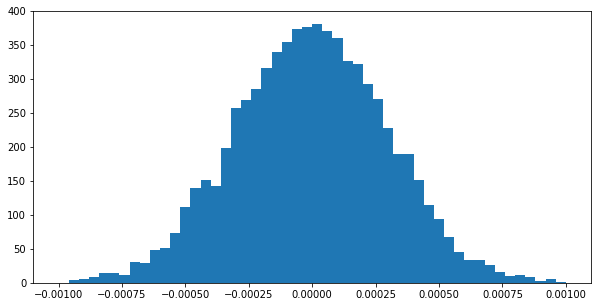

In [10]:
# Example-09: Frequency vs signal start shift with noise

# Set parameters (1 signal with length 2048)
dtype, device = torch.float64, 'cpu'
size, length = 1, 8192

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (1 signals with two components)
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)
print(tbt)

# Generate matrix frim signal
tbt = tbt.make_matrix(0, 1024, 1, name='cosine_window', order=1.0)
print(tbt)

# Add noise to each signal
for i in range(tbt.size):
    tbt.data[i] += 0.01*torch.randn(tbt.length, dtype=dtype, device=device)
tbt.reset()

# Initialize Frequency instance
f = Frequency(tbt)

# Estimate frequency
f('parabola', window=True)
print(torch.mean(f.fft_frequency)-0.12)
print(torch.mean(f.ffrft_frequency)-0.12)
print(torch.mean(f.parabola_frequency)-0.12)

# Plot result
plt.figure(figsize=(10,5))
plt.hist((f.parabola_frequency.cpu().numpy()-0.12)/0.12 * 100, bins=50, range=(-0.001, 0.001))
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(8192, 'cosine_window', 1.0)
Data(1, Window(8192, 'cosine_window', 1.0))
Data(7169, Window(1024, 'cosine_window', 1.0))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(1.067838537178e-07, dtype=torch.float64)
tensor(1.297869460515e-08, dtype=torch.float64)


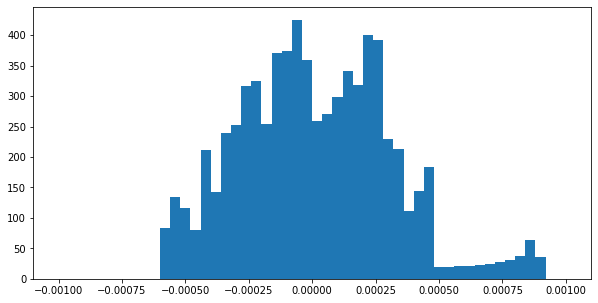

In [11]:
# Example-10: Frequency vs signal start shift (correlated noise)

# Set parameters (1 signal with length 2048)
dtype, device = torch.float64, 'cpu'
size, length = 1, 8192

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(win)

# Set TbT data (1 signals with two components and random noise)
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
data += 0.01*torch.randn(length, dtype=dtype, device=device)
tbt = Data.from_tensor(win, data)
print(tbt)

# Generate matrix frim signal
tbt = tbt.make_matrix(0, 1024, 1, name='cosine_window', order=1.0)
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)

# Estimate frequency
f('parabola', window=True)
print(torch.mean(f.fft_frequency)-0.12)
print(torch.mean(f.ffrft_frequency)-0.12)
print(torch.mean(f.parabola_frequency)-0.12)

# Plot result
plt.figure(figsize=(10,5))
plt.hist((f.parabola_frequency.cpu().numpy()-0.12)/0.12 * 100, bins=50, range=(-0.001, 0.001))
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

In [12]:
# Example-11: Decomposition

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 1, 1024

# Set window
win = Window.from_cosine(length, order=4.0, dtype=dtype, device=device)

# Set data
time  = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data  = 1.0000*torch.cos(2.0*numpy.pi*1*0.12*time) + 0.10000*torch.sin(2.0*numpy.pi*1*0.12*time)
data += 0.0050*torch.cos(2.0*numpy.pi*2*0.12*time) + 0.01000*torch.sin(2.0*numpy.pi*2*0.12*time)
data += 0.0001*torch.cos(2.0*numpy.pi*3*0.12*time) + 0.00001*torch.sin(2.0*numpy.pi*3*0.12*time)
data += 2.0
data  = torch.stack([data])

tbt = Data.from_tensor(win, data)

# Compute (window weighted) mean value
print(tbt.window_mean().flatten().cpu().numpy())

# Remove (window weighted) mean value
# Note, mean is removed from work
tbt.window_remove_mean()
tbt.data.copy_(tbt.work)

# Initialize Frequency instance
f = Frequency(tbt)

# Perform decomposition (component-by-component subtraction)
for _ in range(3):
    f('parabola')
    frequency = f.frequency[0]
    c_amp = 2.0*torch.dot(tbt[0]*win.data, torch.cos(2.0*numpy.pi*frequency*time))/win.total
    s_amp = 2.0*torch.dot(tbt[0]*win.data, torch.sin(2.0*numpy.pi*frequency*time))/win.total
    print(torch.stack([frequency, c_amp, s_amp]).cpu().numpy())
    rem = c_amp*torch.cos(2.0*numpy.pi*frequency*time) + s_amp*torch.sin(2.0*numpy.pi*frequency*time)
    tbt.data.sub_(rem)
    tbt.reset()

# Residual norm
print(torch.sum(torch.sqrt(tbt.data**2)).item())

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

[2.]
[0.12 1.   0.1 ]
[0.24  0.005 0.01 ]
[3.6e-01 1.0e-04 1.0e-05]
5.759385082140556e-09


In [13]:
# Example-12: Test TbT data for VEPP lattice

# Set window
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')

# Load TbT data from file
tbt = Data.from_file(54, win, 'virtual_tbt.npy')

# Compute frequencies
f = Frequency(tbt)
print(f)
f('parabola')
f1 = f.frequency.mean()
print(f1)

# Generate mixed signal
tbt = tbt.make_signal(64, name='cosine_window', order=1.0)

# Compute frequency
f = Frequency(tbt)
print(f)
f('parabola')
print(54*f.frequency.mean())
f2 = 1.0 - (54*f.frequency.mean() - 8.0)
print(f2)

# Compare
print(f1 - f2)

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Frequency(Data(54, Window(4096, 'cosine_window', 1.0)))
tensor(4.614859044162e-01, dtype=torch.float64)
Frequency(Data(1, Window(3456, 'cosine_window', 1.0)))
tensor(8.538511986070e+00, dtype=torch.float64)
tensor(4.614880139297e-01, dtype=torch.float64)
tensor(-2.109513519255e-06, dtype=torch.float64)


Window(4096, 'cosine_window', 1.0)
Data(54, Window(4096, 'cosine_window', 1.0))
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)))


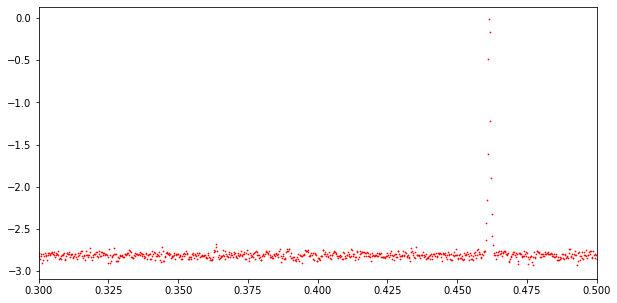

In [14]:
# Example-13: Mean spectrum

# Set window
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')
print(win)

# Load TbT data from file and add noise
tbt = Data.from_file(54, win, 'virtual_tbt.npy')
std = 1.0E-4 * torch.ones(54, dtype=torch.float64)
Data.add_noise(tbt.data, std)
tbt.reset()
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Frequencies are used for mean spectrum normalization

# Compute frequencies
f('parabola')

# Compute mean spectrum
grid, spectrum = f.task_mean_spectrum(window=True, log=True)

# Plot
plt.figure(figsize=(10,5))
plt.xlim(0.3, 0.5)
plt.scatter(grid.cpu(), spectrum.cpu(), s=0.5, c='r')
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, 'cosine_window', 1.0)
Data(54, Window(4096, 'cosine_window', 1.0))
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)))


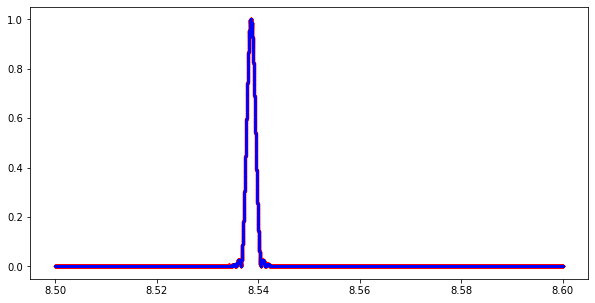

In [15]:
# Example-14: Mixed spectrum

# Set positions
df = pandas.read_json('bpm.json')
position = numpy.array([df[name]['S'] for name in df])/LENGTH

# Set window
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')
print(win)

# Load TbT data from file and add noise
tbt = Data.from_file(54, win, 'virtual_tbt.npy')
std = 1.0E-4 * torch.ones(54, dtype=torch.float64)
Data.add_noise(tbt.data, std)
tbt.reset()
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Compute & plot mixed spectrum
f_range=(8.5, 8.6)
s1 = f.task_mixed_spectrum(length=1024, window=True, normalize=True, f_range=f_range)
s2 = f.task_mixed_spectrum(length=1024, window=True, normalize=True, f_range=f_range, position=position)
plt.figure(figsize=(10,5))
plt.scatter(*s1, c='r', s=5)
plt.scatter(*s2, c='b', s=1)
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

In [16]:
# Example-15: Mixed frequency (without noise)

# Set positions
df = pandas.read_json('bpm.json')
position = numpy.array([df[name]['S'] for name in df])/LENGTH

# Set window
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')
print(win)

# Load TbT data from file and add noise
tbt = Data.from_file(54, win, 'virtual_tbt.npy')

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Compute frequencies
f('parabola')
mean = torch.mean(f.frequency).item()
std = torch.std(f.frequency).item()
print(mean)
print(std)

# Compute mixed frequencies

# For small number of turns, result might be more accurate without window

length = 32

f1 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True)
print(f1.cpu().numpy())
print((1-(f1[-1]-8)-mean).item())

f2 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=position)
print(f2.cpu().numpy())
print((1-(f2[-1]-8)-mean).item())

# Compute using large number of turns

length = 4096

f1 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True)
print(f1.cpu().numpy())
print((1-(f1[-1]-8)-mean).item())

f2 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=position)
print(f2.cpu().numpy())
print((1-(f2[-1]-8)-mean).item())

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, 'cosine_window', 1.0)
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)))
0.461485904416196
1.1758247157674714e-13
[8.53125    8.53855613 8.53854627]
-3.217357037071933e-05
[8.53877315 8.53851997 8.53853624]
-2.214332584776768e-05
[8.53857422 8.5385141  8.5385141 ]
-1.5265566588595902e-14
[8.53851544 8.5385141  8.5385141 ]
-4.055877300679356e-10


In [17]:
# Example-16: Mixed frequency (with noise)

# Set positions
df = pandas.read_json('bpm.json')
position = numpy.array([df[name]['S'] for name in df])/LENGTH

# Set window
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')
print(win)

# Load TbT data from file and add noise
tbt = Data.from_file(54, win, 'virtual_tbt.npy')
std = 1.0E-4 * torch.ones(54, dtype=torch.float64)
Data.add_noise(tbt.data, std)
tbt.reset()
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Compute frequencies
f('parabola')
mean = torch.mean(f.frequency).item()
std = torch.std(f.frequency).item()
print(mean)
print(std)

# Compute mixed frequencies

# For small number of turns, result might be more accurate without window

length = 32

f1 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True)
print(f1.cpu().numpy())
print((1-(f1[-1]-8)-mean).item())

f2 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=position)
print(f2.cpu().numpy())
print((1-(f2[-1]-8)-mean).item())

# Compute using large number of turns

length = 4096

f1 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True)
print(f1.cpu().numpy())
print((1-(f1[-1]-8)-mean).item())

f2 = f.task_mixed_frequency(length=length, window=True, f_range=(8,9), normalize=True, position=position)
print(f2.cpu().numpy())
print((1-(f2[-1]-8)-mean).item())

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, 'cosine_window', 1.0)
Data(54, Window(4096, 'cosine_window', 1.0))
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)))
0.46148591127750155
2.3306610240477248e-07
[8.53125    8.53851997 8.53853009]
-1.5999975121194776e-05
[8.53877315 8.53851997 8.53850249]
1.1595940912878522e-05
[8.53857422 8.53851401 8.53851401]
8.00423083924251e-08
[8.53851544 8.53851402 8.53851402]
6.675200620032129e-08


Window(1024, 'cosine_window', 1.0)
Frequency(Data(128, Window(1024, 'cosine_window', 1.0)))


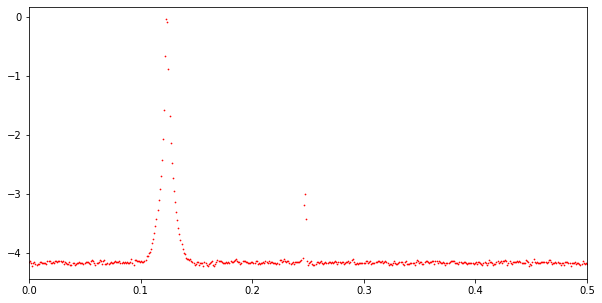

In [18]:
# Example-17: Mean spectrum (masked component)

# Set window
win = Window(1024, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')
print(win)

# Set data
time = torch.linspace(1.0, len(win), len(win), dtype=win.dtype)
data = torch.cos(2.0*numpy.pi*0.12345*time) + 1.E-3*torch.cos(2.0*numpy.pi*2.0*0.12345*time)
data = torch.stack([data + 1.E-3*torch.randn(len(win)) for _ in range(128)])

# Set TbT
tbt = Data.from_tensor(win, data)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Compute frequencies
f('parabola')

# Compute mean spectrum
grid, spectrum = f.task_mean_spectrum(window=True, log=True)

# Plot
plt.figure(figsize=(10,5))
plt.xlim(0.0, 0.5)
plt.scatter(grid.cpu(), spectrum.cpu(), s=0.5, c='r')
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

## Frequency (nonuniform sampling)

0. zoom better than bracket (CR bound), window against bias, but want resolution

1. single location sr1 case (uniform and 'stationary' if quasiperiodic). Mirror. Aliacing and leakage. Frequencies appear at low frequencies. E.g. f=2.1, seen at 0.1, 1.1 (also at 3.1 and etc). Mirror around center. E.g. have 0.6, see 0.4 + n * SR. Bias from all above. High bias for small # of turns. But can average.

2. multiple locations for uniform and stationary (f + f_mirror) + n * SR. Same bias, but spaced. More info.

3. periodic (mixed data) + ignore non-uniform staff + remove mean + normalization (i.e. close to stationary), have n*SR and 1*SR, max is not guaranted to be at correct location. Got problems from aliacing and leakage of 1*SR bleed, 1*SR, 2*SR, ...., N*SR bleed

4. periodic (mixed data) TYPE-III NUFFT: include positions (or phase advance), reduce n*SR and 1*SR significantly, main should be OK, problems should be reduced (need tests)

5. all random, if pos are ignored -- nothing new, if t3 -- boom!!! super resolution (assuming stationary case)

6. ok, how to get 5?
    -- use t3 with s or mu + normalization --> stationary case
    -- sample randomly at each turn (not exactly 5, but should be close)
    -- bpm shift? tansform is drift? (more rng)
    
7. why?
    -- reduce effectc of aliace/leakage/mirror
    -- what about noise?
    -- obtain super resolution, find harmonics (compute section by section), cool spectrum
    
8. ok, select randomly, but positions are still fixed, random effect from sampling new random positions in combination with sparse signal structure
    -- how to do it? expect random sampling (selection) to work not optimal
    -- use filters and model to get x and px, can compute  close to BPMs
    -- say in some region adound BPM expect to have OK coordinates
    -- select at random in regions!

In [4]:
import numpy
import pandas
import torch
import nufft

from harmonica.util import LENGTH, QX, QY
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
torch.cuda.is_available()

False

In [236]:
Test nufft function parameters
Add kwargs and pass to it
only eps, test it
# no eggect from eps
# type-1 -- strange

Simple example of mixed data
Take sin and nonuniform sampling
Paired artifacts?
Illustrate max range for multy component, alliacing modulo sampling rate
# no artifacts
# stange pic for t3, no aliasing (cas nonuniform?)
# need to compare with normal loop
# looks like there is a paired artifact, or can't compute for some reason

Test small number of turns
Compare averaged from normal loop vs mixed with and without window and with noise
Sure if second harmonic is close, bias will be high, but application of window might overlap

SyntaxError: invalid syntax (<ipython-input-236-076deea80897>, line 1)

In [ ]:
nufft.nufft1d3()
nufft.nufft1d1()

Window(4096, 'cosine_window', 1.0)
Data(54, Window(4096, 'cosine_window', 1.0))
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)))


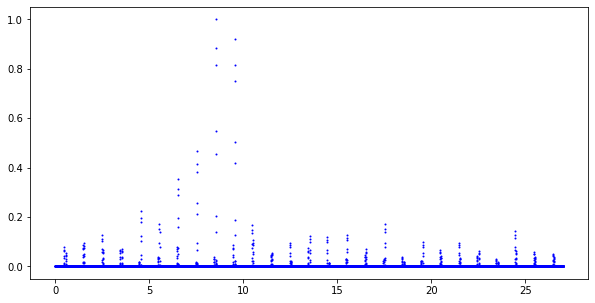

In [8]:
# Set positions
df = pandas.read_json('bpm.json')
position = numpy.array([df[name]['S'] for name in df])/LENGTH

# Set window
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')
print(win)

# Load TbT data from file and add noise
tbt = Data.from_file(54, win, 'virtual_tbt.npy')
std = 1.0E-4 * torch.ones(54, dtype=torch.float64)
Data.add_noise(tbt.data, std)
tbt.reset()
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Compute & plot mixed spectrum
f_range=(0.0, 54.0/2.0)
s1 = f.task_mixed_spectrum(length=1024, window=True, normalize=True, f_range=f_range)
s2 = f.task_mixed_spectrum(length=1024, window=True, normalize=True, f_range=f_range, position=position)
plt.figure(figsize=(10,5))
# plt.scatter(*s1, c='r', s=5)
plt.scatter(*s2, c='b', s=1)
plt.show()

# Clean
del win
del tbt
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, 'cosine_window', 1.0)
Data(54, Window(4096, 'cosine_window', 1.0))
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)))


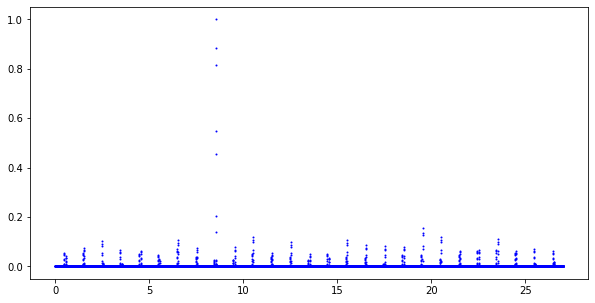

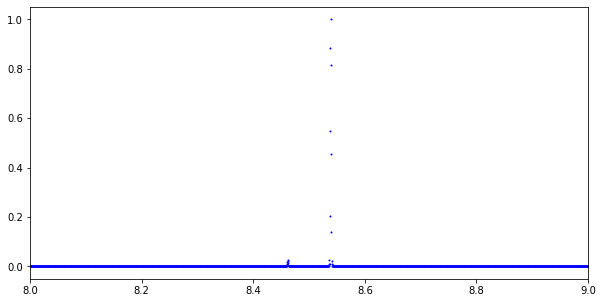

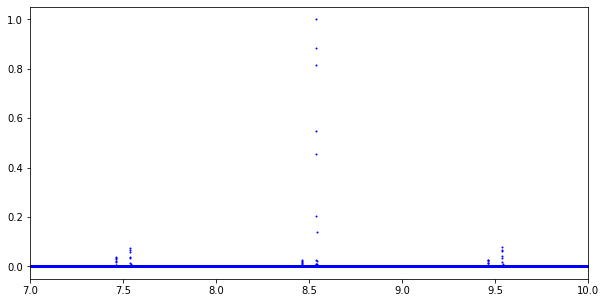

In [329]:
# Set positions
df = pandas.read_json('bpm.json')
FX = numpy.array([df[name]["FX"] for name in df])
FX = numpy.cumsum(FX)/(2.0*numpy.pi*QX)
position = FX
position = position-position[0]

# Set window
win = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')
print(win)

# Load TbT data from file and add noise
tbt = Data.from_file(54, win, 'virtual_tbt.npy')
std = 1.0E-4 * torch.ones(54, dtype=torch.float64)
Data.add_noise(tbt.data, std)
tbt.reset()
print(tbt)

# Initialize Frequency instance
f = Frequency(tbt)
print(f)

# Compute & plot mixed spectrum
f_range=(0.0, 54.0/2.0)
s1 = f.task_mixed_spectrum(length=1024, window=True, normalize=True, f_range=f_range)
s2 = f.task_mixed_spectrum(length=1024, window=True, normalize=True, f_range=f_range, position=position)
plt.figure(figsize=(10,5))
# plt.scatter(*s1, c='r', s=5)
plt.scatter(*s2, c='b', s=1)
plt.show()

# # Clean
# del win
# del tbt
# del f
# if device != 'cpu':
#     torch.cuda.synchronize()
#     torch.cuda.empty_cache()

# each one and around
plt.figure(figsize=(10,5))
# plt.scatter(*s1, c='r', s=5)
plt.xlim(8., 9.) # -- around
plt.scatter(*s2, c='b', s=1)
plt.show()

plt.figure(figsize=(10,5))
# plt.scatter(*s1, c='r', s=5)
plt.xlim(7., 10.) # -- around
plt.scatter(*s2, c='b', s=1)
plt.show()

torch.Size([5120])


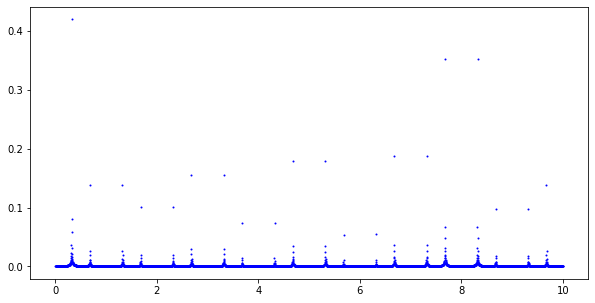

Data(1, Window(5120, None, None))


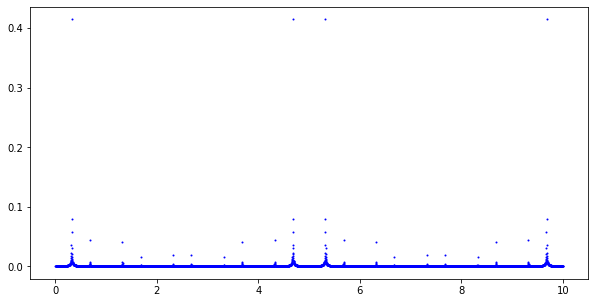

In [330]:
# NOT EQUIDISTANT
# FIXED (CORRELATED) PERIODIC

dtype = torch.float64
device = 'cpu'
rate = 5
length = 1024
time = torch.sort(torch.rand(rate, dtype=dtype)).values
time = torch.cat([time + i for i in range(length)])

frequency = [0.32]
signal = torch.sum(torch.stack([0.85**i*torch.cos(2.0*numpy.pi*frequency[i]*time) for i in range(len(frequency))]), 0)
print(signal.shape)

f_min, f_max = 0.0, 10
fre = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(time) + 1)
fou = nufft.nufft1d3(time, signal, fre)

plt.figure(figsize=(10,5))
plt.scatter(fre/(2.0*numpy.pi), numpy.abs(fou), c='b', s=1)
plt.show()

win = Window(len(signal))
tbt = Data.from_tensor(win, torch.unsqueeze(signal, 0))
print(tbt)

f_min, f_max = f_min/rate, f_max/rate
span = (f_max - f_min)
center = f_min + 0.5*span

f= Frequency(tbt)
f('parabola', center=center, span=span)
x = rate*f.ffrft_get_grid(0)
y = f.ffrft_spectrum[0]/len(x)

plt.figure(figsize=(10,5))
plt.scatter(x, y, c='b', s=1)
plt.show()


In [ ]:
# strange with rangom sampling, kotelnikov is not applicable, but amp is contant to here

torch.Size([5120])


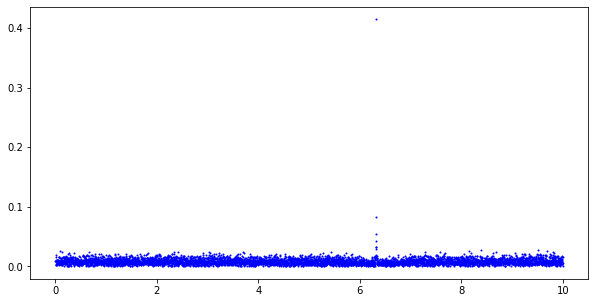

Data(1, Window(5120, None, None))


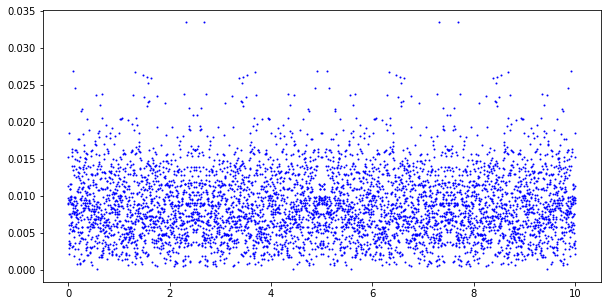

In [325]:
# NOT EQUIDISTANT, RANDOM

# note, it's random every time!!!! i.e. lots of info

dtype = torch.float64
device = 'cpu'
rate = 5
length = 1024
time = torch.cat([torch.sort(torch.rand(rate, dtype=dtype)).values + i for i in range(length)])

frequency = [6.32]
signal = torch.sum(torch.stack([0.85**i*torch.cos(2.0*numpy.pi*frequency[i]*time) for i in range(len(frequency))]), 0)
print(signal.shape)

f_min, f_max = 0.0, 10
fre = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(time) + 1)
fou = nufft.nufft1d3(time, signal, fre)

plt.figure(figsize=(10,5))
plt.scatter(fre/(2.0*numpy.pi), numpy.abs(fou), c='b', s=1)
plt.show()

win = Window(len(signal))
tbt = Data.from_tensor(win, torch.unsqueeze(signal, 0))
print(tbt)

f_min, f_max = f_min/rate, f_max/rate
span = (f_max - f_min)
center = f_min + 0.5*span

f= Frequency(tbt)
f('parabola', center=center, span=span)
x = rate*f.ffrft_get_grid(0)
y = f.ffrft_spectrum[0]/len(x)

plt.figure(figsize=(10,5))
plt.scatter(x, y, c='b', s=1)
plt.show()


torch.Size([5120])


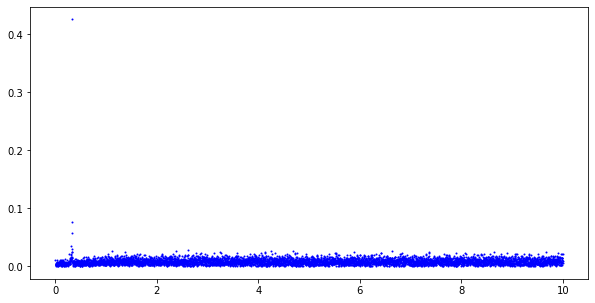

Data(1, Window(5120, None, None))


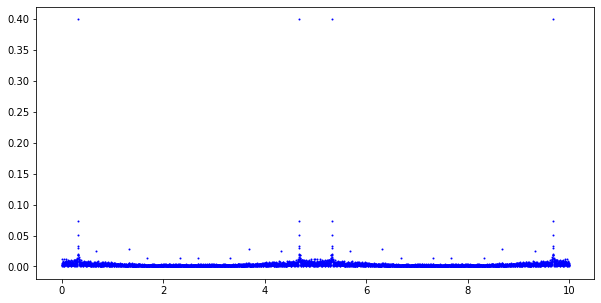

In [322]:
# NOT EQUIDISTANT, RANDOM

dtype = torch.float64
device = 'cpu'
rate = 5
length = 1024
time = torch.cat([torch.sort(torch.rand(rate, dtype=dtype)).values + i for i in range(length)])

# time = torch.cat([torch.linspace(0.0, 1.0-1/rate, rate, dtype=dtype) + i for i in range(length)])

frequency = [0.32]
signal = torch.sum(torch.stack([0.85**i*torch.cos(2.0*numpy.pi*frequency[i]*time) for i in range(len(frequency))]), 0)
print(signal.shape)

f_min, f_max = 0.0, 10
fre = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(time) + 1)
fou = nufft.nufft1d3(time, signal, fre)

plt.figure(figsize=(10,5))
plt.scatter(fre/(2.0*numpy.pi), numpy.abs(fou), c='b', s=1)
plt.show()

win = Window(len(signal))
tbt = Data.from_tensor(win, torch.unsqueeze(signal, 0))
print(tbt)

f_min, f_max = f_min/rate, f_max/rate
span = (f_max - f_min)
center = f_min + 0.5*span

f= Frequency(tbt)
f('parabola', center=center, span=span)
x = rate*f.ffrft_get_grid(0)
y = f.ffrft_spectrum[0]/len(x)

plt.figure(figsize=(10,5))
plt.scatter(x, y, c='b', s=1)
plt.show()

### HM
## nonuniform => noperiodic???
## got sone extra artifacts for ffrft

torch.Size([5120])


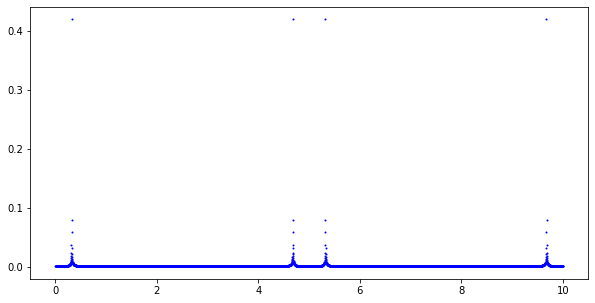

Data(1, Window(5120, None, None))


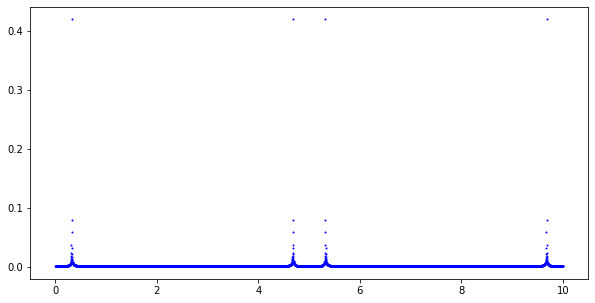

In [315]:
# EXAMPLE OF PAIRED WHEN RATE, EQUIDISTANT
dtype = torch.float64
device = 'cpu'
rate = 5
length = 1024
# time = torch.cat([torch.sort(torch.rand(length, dtype=dtype)).values + i for i in range(rate)])

time = torch.cat([torch.linspace(0.0, 1.0-1/rate, rate, dtype=dtype) + i for i in range(length)])

frequency = [5.1234, 20.1, 28.76543, 31.45, 35.1231*0.0]
frequency = [0.32]
signal = torch.sum(torch.stack([0.85**i*torch.cos(2.0*numpy.pi*frequency[i]*time) for i in range(len(frequency))]), 0)
print(signal.shape)

f_min, f_max = 0.0, 10
fre = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(time) + 1)
fou = nufft.nufft1d3(time, signal, fre)

plt.figure(figsize=(10,5))
plt.scatter(fre/(2.0*numpy.pi), numpy.abs(fou), c='b', s=1)
plt.show()

win = Window(len(signal))
tbt = Data.from_tensor(win, torch.unsqueeze(signal, 0))
print(tbt)

f_min, f_max = f_min/rate, f_max/rate
span = (f_max - f_min)
center = f_min + 0.5*span

f= Frequency(tbt)
f('parabola', center=center, span=span)
x = rate*f.ffrft_get_grid(0)
y = f.ffrft_spectrum[0]/len(x)

plt.figure(figsize=(10,5))
plt.scatter(x, y, c='b', s=1)
plt.show()